In [1]:
import os
import numpy as np
import pandas as pd
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, matthews_corrcoef
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import seaborn as sns
import time

SEED = 42
os.environ["WANDB_MODE"] = "disabled"

# Set seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 


In [ ]:
def compute_metrics(eval_pred):
    """
    Computes binary classification metrics from model predictions.

    Args:
        eval_pred (tuple): A tuple containing (logits, labels) where logits are 
            the raw output scores from the model and labels are the ground truth.

    Returns:
        dict: A dictionary containing Accuracy, F1-score, Precision, and Recall.
    """
    
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        }

def tokenize_function(examples):
    """
    Tokenize input data

    Args:
        example (dataset): Dataset input for model
    """
    return tokenizer(examples["seq_name"], padding="max_length", truncation=True, max_length=256)

def calculate_model_size(model, model_name):
    """
    Analyzes and prints the physical size and parameter count of the model.

    Args:
        model (nn.Module): The PyTorch model to analyze.
        model_name (str): A descriptive name for the model.
    """
    # 1. Total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # 2. Model size on memory
    param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size_bytes = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size_bytes = param_size_bytes + buffer_size_bytes

    print("\n" + "=" * 50)
    print(f"{model_name} Size Analysis")

    print(f"Total Parameters: {total_params} ({total_params/1e6:.2f}M)")
    print(f"Trainable Parameters: {trainable_params} ({total_params/1e6:.2f}M)")
    print(f"Total size in memory: {total_size_bytes / (1024**2) :.2f}MB")


    print("=" * 50 + "\n")


# Plot graph
def evaluate_on_test_dataset_with_inference_test(trainer, dataset):
    """
    Performs evaluation on a test set, including inference speed benchmarks.

    Args:
        trainer (transformers.Trainer): The initialized Hugging Face Trainer object.
        dataset (Dataset): The test dataset to evaluate against.

    Returns:
        float: The final accuracy score achieved on the test dataset.
    """

  # Inference time measurement
    model = trainer.model
    model.eval()
    device = model.device

    dataloader = trainer.get_eval_dataloader(dataset)

    all_labels = []
    all_preds = []
    all_probs = []

    total_time = 0.0
    total_samples = 0


    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= 5:
                break
            batch = {k: v.to(device) for k, v in batch.items()}
            _ = model(**batch)

    with torch.no_grad():
        for batch in dataloader:
        labels_batch = batch['labels'].cpu().numpy() # Renamed to avoid confusion with overall 'labels'
        batch = {k: v.to(device) for k, v in batch.items() if k != "labels"}

        if device.type == "cuda":
            torch.cuda.synchronize()
        start = time.time()

        outputs = model(**batch)

        if device.type == "cuda":
            torch.cuda.synchronize()
        end = time.time()

        total_time += end - start
        total_samples += batch['input_ids'].size(0)

        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(labels_batch)

    # Concatenate collected lists into numpy arrays for metrics calculation
    all_preds_np = np.array(all_preds)
    all_probs_np = np.array(all_probs)
    all_labels_np = np.array(all_labels)

    accuracy = accuracy_score(all_labels_np, all_preds_np)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels_np, all_preds_np, average='binary', zero_division=0)
    mcc = matthews_corrcoef(all_labels_np, all_preds_np)

    latency_ms = (total_time / total_samples) * 1000 if total_samples > 0 else 0
    throughput = total_samples / total_time if total_time > 0 else 0

    print(f"\n==============Evaluation Matrics on test set==============")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"MCC      : {mcc:.4f}")
    print(f"Latency  : {latency_ms:.2f} ms/sample")
    print(f"Speed    : {throughput:.2f} samples/sec")
    print(f"==========================================================\n")

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(all_labels_np, all_preds_np)
    disp = ConfusionMatrixDisplay(cm, display_labels=['non-AMP', 'AMP'])
    disp.plot(ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

    # AUC/ROC
    fpr, tpr, _ = roc_curve(all_labels_np, all_probs_np[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy

## Dataset

In [3]:
dataset = Dataset.from_csv("dataset/AMP.csv").rename_column('label', 'labels')
train_dataset = dataset.train_test_split(test_size=0.2, seed=SEED)

test_dataset = Dataset.from_csv("dataset/abp.indtest1.csv").rename_column('label', 'labels')

In [4]:
def run_finetune_experiment(
    model_path,
    model_name,
    train_dataset,
    test_dataset,
    output_dir,
    temperature=2,
    learning_rate=2e-5,
    epochs=5,
    batch_size=256,
    seed=42
):
    """
    Executes a fine-tuning experiment using Knowledge Distillation and evaluates on a test set.

    Args:
        model_path (str): Path or Hugging Face identifier for the pre-trained model.
        train_dataset (Dataset): The dataset used for model fine-tuning.
        test_dataset (Dataset): The dataset used for model evaluation.
        output_dir (str): Directory where the fine-tuned model and logs will be saved.
        temperature (int, optional): Hyperparameter to soften the probability distribution during distillation. Defaults to 2.
        learning_rate (float, optional): Step size for the optimizer during training. Defaults to 2e-5.
        epoch (int, optional): Total number of training passes over the entire dataset. Defaults to 5.
        batch_size (int, optional): Number of samples processed per training step. Defaults to 256.
        seed (int, optional): Random seed to ensure experimental reproducibility. Defaults to 42.
    """

    print(f"---- Start experimenting {model_name} ----")

    # 1. Load Model & Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    student_model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # 2. Tokenize Dataset
    def tokenize_fn(examples):
        return tokenizer(examples["seq_name"], padding="max_length", truncation=True, max_length=256)

    print("Tokenizing dataset.....")
    tokenized_train = train_dataset.map(tokenize_fn, batched=True)
    tokenized_test = test_dataset.map(tokenize_fn, batched=True)

    # 3. Training Arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_steps=20,
        logging_strategy="epoch",
        seed=seed,
        data_seed=seed,
    )

    # 4. Initialize Trainer
    trainer = Trainer(
        model=student_model,
        args=training_args,
        train_dataset=tokenized_train['train'],
        eval_dataset=tokenized_train['test'],
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
    )

    # 5. Model Size Analysis
    calculate_model_size(student_model, model_name)

    # 6. Train & Evaluate
    trainer.train()

    print(f"\nEvaluating on Test Set")
    evaluate_on_test_dataset_with_inference_test(trainer, tokenized_test)

#### Alpha = 0 temp =  2

---- Start experimenting distilESM-2-AMP (a=0, temperature=2) ----


Loading weights:   0%|          | 0/56 [00:00<?, ?it/s]

EsmForSequenceClassification LOAD REPORT from: ./models/temp_2_a_0
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.bias    | UNEXPECTED | 
classifier.out_proj.bias   | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.dense.weight    | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Tokenizing dataset.....


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



distilESM-2-AMP (a=0, temperature=2) Size Analysis
Total Parameters: 3813503 (3.81M)
Trainable Parameters: 3813503 (3.81M)
Total size in memory: 14.56MB



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.482952,0.219918,0.941577,0.943747,0.919149,0.969697
2,0.179786,0.158304,0.948951,0.950166,0.937705,0.962963
3,0.146972,0.149006,0.949518,0.950279,0.946051,0.954545
4,0.136300,0.143894,0.950085,0.950838,0.946607,0.955107
5,0.130484,0.142900,0.951220,0.952036,0.946231,0.957912


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.weight', 'esm.encoder.layer.0.attention.LayerNorm.bias', 'esm.encoder.layer.0.LayerNorm.weight', 'esm.encoder.layer.0.LayerNorm.bias', 'esm.encoder.layer.1.attention.LayerNorm.weight', 'esm.encoder.layer.1.attention.LayerNorm.bias', 'esm.encoder.layer.1.LayerNorm.weight', 'esm.encoder.layer.1.LayerNorm.bias', 'esm.encoder.layer.2.attention.LayerNorm.weight', 'esm.encoder.layer.2.attention.LayerNorm.bias', 'esm.encoder.layer.2.LayerNorm.weight', 'esm.encoder.layer.2.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.beta', 'esm.encoder.layer.0.attention.LayerNorm.gamma', 'esm.encoder.layer.0.LayerNorm.beta', 'esm.encoder.layer.0.LayerNorm.gamma', 'esm.encoder.layer.1.attention.LayerNorm.beta', 'esm.encoder.layer.1.attention.LayerNorm.gamma', 'esm.encoder.layer.1.LayerNorm.beta', 'esm.encoder.layer.1.LayerNorm.gamma', 'esm.e


Evaluating on Test Set

==============Evaluation Matrics on test set==============
Accuracy : 0.9650
Precision: 0.9568
Recall   : 0.9740
F1-score : 0.9653
MCC      : 0.9302
Latency  : 0.33 ms/sample
Speed    : 2995.24 samples/sec



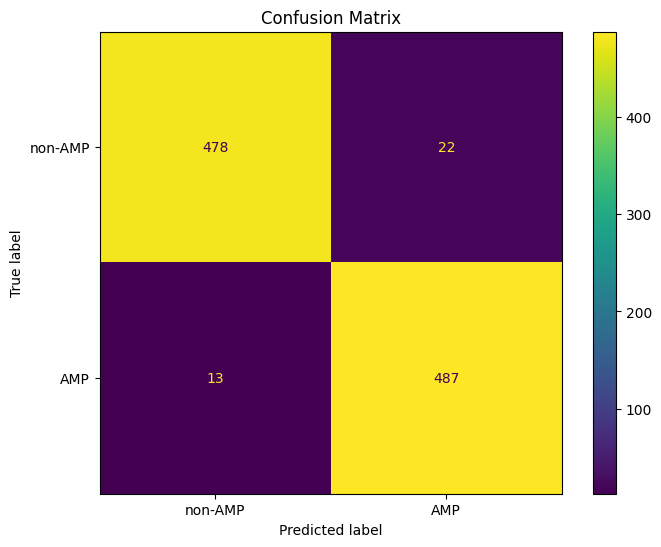

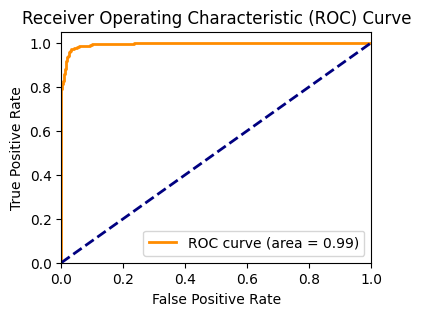

In [5]:
run_finetune_experiment(
    model_path="./models/temp_2_a_0",
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir="./amp_student_alpha_0",
    model_name="distilESM-2-AMP (a=0, temperature=2)"
)

#### Alpha = 0.25 temp =  2

---- Start experimenting distilESM-2-AMP (a=0.25, temperature=2) ----


Loading weights:   0%|          | 0/56 [00:00<?, ?it/s]

EsmForSequenceClassification LOAD REPORT from: ./models/temp_2_a_0.25
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.bias    | UNEXPECTED | 
classifier.out_proj.bias   | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.dense.weight    | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Tokenizing dataset.....

distilESM-2-AMP (a=0.25, temperature=2) Size Analysis
Total Parameters: 3813503 (3.81M)
Trainable Parameters: 3813503 (3.81M)
Total size in memory: 14.56MB



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.482010,0.207920,0.942144,0.944323,0.919235,0.970819
2,0.167698,0.152517,0.948383,0.949696,0.935730,0.964085
3,0.140666,0.144933,0.948383,0.949020,0.947427,0.950617
4,0.131563,0.140252,0.951503,0.952195,0.948747,0.955668
5,0.125074,0.139064,0.952354,0.953099,0.948333,0.957912


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.weight', 'esm.encoder.layer.0.attention.LayerNorm.bias', 'esm.encoder.layer.0.LayerNorm.weight', 'esm.encoder.layer.0.LayerNorm.bias', 'esm.encoder.layer.1.attention.LayerNorm.weight', 'esm.encoder.layer.1.attention.LayerNorm.bias', 'esm.encoder.layer.1.LayerNorm.weight', 'esm.encoder.layer.1.LayerNorm.bias', 'esm.encoder.layer.2.attention.LayerNorm.weight', 'esm.encoder.layer.2.attention.LayerNorm.bias', 'esm.encoder.layer.2.LayerNorm.weight', 'esm.encoder.layer.2.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.beta', 'esm.encoder.layer.0.attention.LayerNorm.gamma', 'esm.encoder.layer.0.LayerNorm.beta', 'esm.encoder.layer.0.LayerNorm.gamma', 'esm.encoder.layer.1.attention.LayerNorm.beta', 'esm.encoder.layer.1.attention.LayerNorm.gamma', 'esm.encoder.layer.1.LayerNorm.beta', 'esm.encoder.layer.1.LayerNorm.gamma', 'esm.e


Evaluating on Test Set

==============Evaluation Matrics on test set==============
Accuracy : 0.9670
Precision: 0.9587
Recall   : 0.9760
F1-score : 0.9673
MCC      : 0.9342
Latency  : 0.33 ms/sample
Speed    : 2992.89 samples/sec



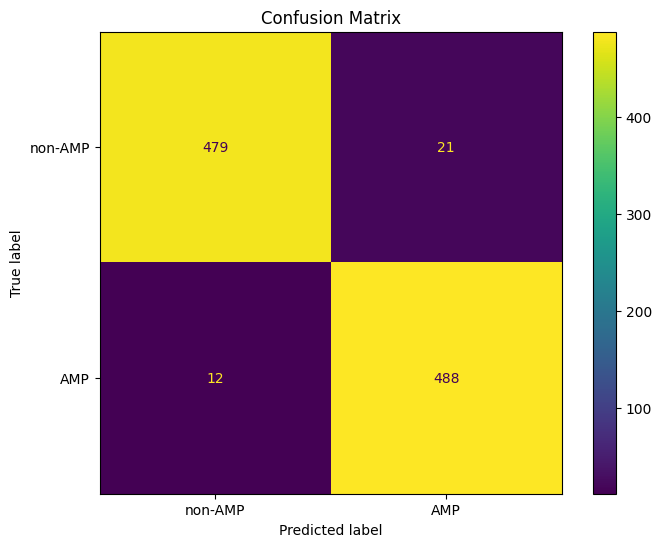

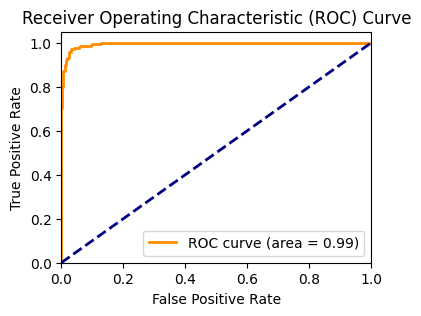

In [6]:
run_finetune_experiment(
    model_path="./models/temp_2_a_0.25",
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir="./amp_student_alpha_0.25",
    model_name="distilESM-2-AMP (a=0.25, temperature=2)"
)

#### Alpha = 0.5 temp =  2

---- Start experimenting distilESM-2-AMP (a=0.5, temperature=2) ----


Loading weights:   0%|          | 0/56 [00:00<?, ?it/s]

EsmForSequenceClassification LOAD REPORT from: ./models/temp_2_a_0.5
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.bias    | UNEXPECTED | 
classifier.out_proj.bias   | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.dense.weight    | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Tokenizing dataset.....

distilESM-2-AMP (a=0.5, temperature=2) Size Analysis
Total Parameters: 3813503 (3.81M)
Trainable Parameters: 3813503 (3.81M)
Total size in memory: 14.56MB



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.481195,0.203566,0.941860,0.944065,0.918747,0.970819
2,0.166803,0.153337,0.947533,0.948853,0.935150,0.962963
3,0.140738,0.147083,0.947533,0.948136,0.947339,0.948934
4,0.132412,0.142466,0.949234,0.949930,0.947016,0.952862
5,0.126274,0.141454,0.950085,0.950893,0.945616,0.956229


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.weight', 'esm.encoder.layer.0.attention.LayerNorm.bias', 'esm.encoder.layer.0.LayerNorm.weight', 'esm.encoder.layer.0.LayerNorm.bias', 'esm.encoder.layer.1.attention.LayerNorm.weight', 'esm.encoder.layer.1.attention.LayerNorm.bias', 'esm.encoder.layer.1.LayerNorm.weight', 'esm.encoder.layer.1.LayerNorm.bias', 'esm.encoder.layer.2.attention.LayerNorm.weight', 'esm.encoder.layer.2.attention.LayerNorm.bias', 'esm.encoder.layer.2.LayerNorm.weight', 'esm.encoder.layer.2.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.beta', 'esm.encoder.layer.0.attention.LayerNorm.gamma', 'esm.encoder.layer.0.LayerNorm.beta', 'esm.encoder.layer.0.LayerNorm.gamma', 'esm.encoder.layer.1.attention.LayerNorm.beta', 'esm.encoder.layer.1.attention.LayerNorm.gamma', 'esm.encoder.layer.1.LayerNorm.beta', 'esm.encoder.layer.1.LayerNorm.gamma', 'esm.e


Evaluating on Test Set

==============Evaluation Matrics on test set==============
Accuracy : 0.9690
Precision: 0.9625
Recall   : 0.9760
F1-score : 0.9692
MCC      : 0.9381
Latency  : 0.33 ms/sample
Speed    : 2992.04 samples/sec



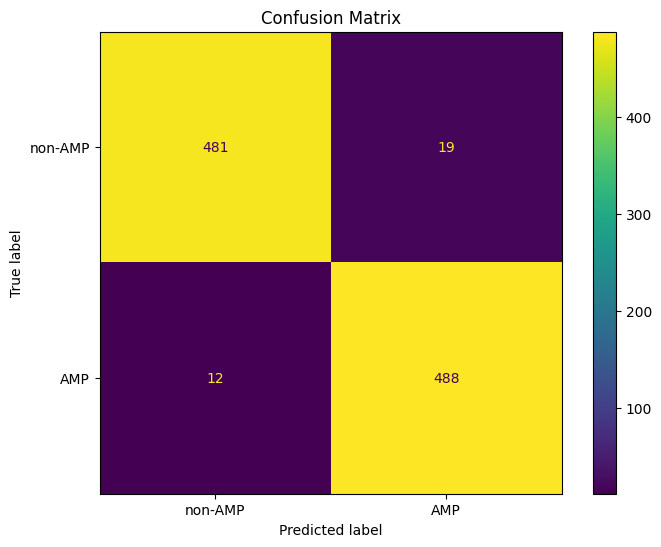

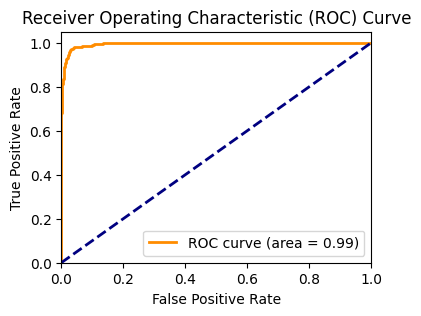

In [7]:
run_finetune_experiment(
    model_path="./models/temp_2_a_0.5",
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir="./amp_student_alpha_0.5",
    model_name="distilESM-2-AMP (a=0.5, temperature=2)"
)

#### Alpha = 0.75 temp =  2

---- Start experimenting distilESM-2-AMP (a=0.75, temperature=2) ----


Loading weights:   0%|          | 0/56 [00:00<?, ?it/s]

EsmForSequenceClassification LOAD REPORT from: ./models/temp_2_a_0.75
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.bias    | UNEXPECTED | 
classifier.out_proj.bias   | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.dense.weight    | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Tokenizing dataset.....


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



distilESM-2-AMP (a=0.75, temperature=2) Size Analysis
Total Parameters: 3813503 (3.81M)
Trainable Parameters: 3813503 (3.81M)
Total size in memory: 14.56MB



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.480042,0.201272,0.942711,0.944869,0.919766,0.971380
2,0.164982,0.152404,0.949518,0.950720,0.938251,0.963524
3,0.138982,0.146355,0.948667,0.949086,0.951495,0.946689
4,0.130232,0.142068,0.950085,0.950700,0.949105,0.952301
5,0.124031,0.141082,0.951787,0.952514,0.948276,0.956790


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.weight', 'esm.encoder.layer.0.attention.LayerNorm.bias', 'esm.encoder.layer.0.LayerNorm.weight', 'esm.encoder.layer.0.LayerNorm.bias', 'esm.encoder.layer.1.attention.LayerNorm.weight', 'esm.encoder.layer.1.attention.LayerNorm.bias', 'esm.encoder.layer.1.LayerNorm.weight', 'esm.encoder.layer.1.LayerNorm.bias', 'esm.encoder.layer.2.attention.LayerNorm.weight', 'esm.encoder.layer.2.attention.LayerNorm.bias', 'esm.encoder.layer.2.LayerNorm.weight', 'esm.encoder.layer.2.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.beta', 'esm.encoder.layer.0.attention.LayerNorm.gamma', 'esm.encoder.layer.0.LayerNorm.beta', 'esm.encoder.layer.0.LayerNorm.gamma', 'esm.encoder.layer.1.attention.LayerNorm.beta', 'esm.encoder.layer.1.attention.LayerNorm.gamma', 'esm.encoder.layer.1.LayerNorm.beta', 'esm.encoder.layer.1.LayerNorm.gamma', 'esm.e


Evaluating on Test Set

==============Evaluation Matrics on test set==============
Accuracy : 0.9680
Precision: 0.9606
Recall   : 0.9760
F1-score : 0.9683
MCC      : 0.9361
Latency  : 0.33 ms/sample
Speed    : 2989.90 samples/sec



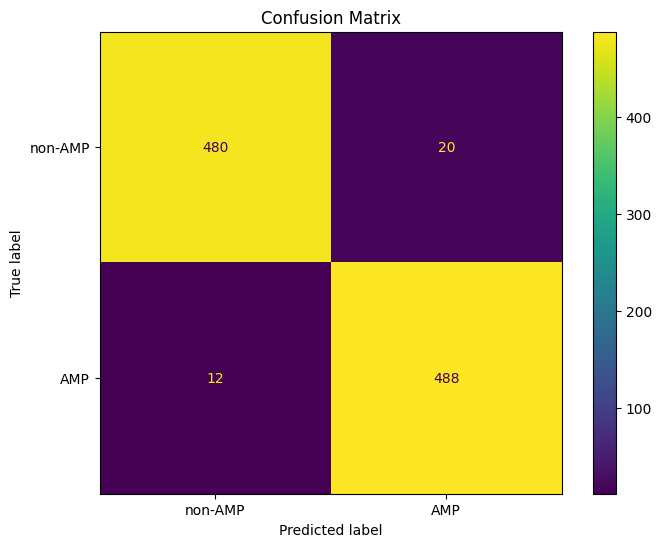

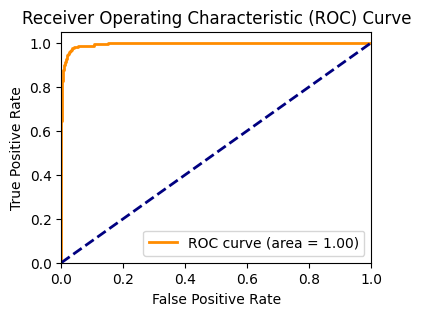

In [8]:
run_finetune_experiment(
    model_path="./models/temp_2_a_0.75",
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir="./amp_student_alpha_0.75",
    model_name="distilESM-2-AMP (a=0.75, temperature=2)"
)

#### Alpha = 1 temp =  2

---- Start experimenting distilESM-2-AMP (a=1, temperature=2) ----


Loading weights:   0%|          | 0/56 [00:00<?, ?it/s]

EsmForSequenceClassification LOAD REPORT from: ./models/temp_2_a_1
Key                        | Status     | 
---------------------------+------------+-
lm_head.layer_norm.weight  | UNEXPECTED | 
lm_head.dense.weight       | UNEXPECTED | 
lm_head.dense.bias         | UNEXPECTED | 
lm_head.bias               | UNEXPECTED | 
lm_head.layer_norm.bias    | UNEXPECTED | 
classifier.out_proj.bias   | MISSING    | 
classifier.out_proj.weight | MISSING    | 
classifier.dense.weight    | MISSING    | 
classifier.dense.bias      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Tokenizing dataset.....

distilESM-2-AMP (a=1, temperature=2) Size Analysis
Total Parameters: 3813503 (3.81M)
Trainable Parameters: 3813503 (3.81M)
Total size in memory: 14.56MB



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.478247,0.202134,0.939875,0.941981,0.919338,0.965769
2,0.166168,0.152365,0.946398,0.947602,0.936438,0.959035
3,0.138949,0.146771,0.948383,0.948876,0.949944,0.947811
4,0.130768,0.143332,0.949234,0.949761,0.950028,0.949495
5,0.124178,0.141886,0.951503,0.952221,0.948247,0.956229


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.weight', 'esm.encoder.layer.0.attention.LayerNorm.bias', 'esm.encoder.layer.0.LayerNorm.weight', 'esm.encoder.layer.0.LayerNorm.bias', 'esm.encoder.layer.1.attention.LayerNorm.weight', 'esm.encoder.layer.1.attention.LayerNorm.bias', 'esm.encoder.layer.1.LayerNorm.weight', 'esm.encoder.layer.1.LayerNorm.bias', 'esm.encoder.layer.2.attention.LayerNorm.weight', 'esm.encoder.layer.2.attention.LayerNorm.bias', 'esm.encoder.layer.2.LayerNorm.weight', 'esm.encoder.layer.2.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.beta', 'esm.encoder.layer.0.attention.LayerNorm.gamma', 'esm.encoder.layer.0.LayerNorm.beta', 'esm.encoder.layer.0.LayerNorm.gamma', 'esm.encoder.layer.1.attention.LayerNorm.beta', 'esm.encoder.layer.1.attention.LayerNorm.gamma', 'esm.encoder.layer.1.LayerNorm.beta', 'esm.encoder.layer.1.LayerNorm.gamma', 'esm.e


Evaluating on Test Set

==============Evaluation Matrics on test set==============
Accuracy : 0.9660
Precision: 0.9587
Recall   : 0.9740
F1-score : 0.9663
MCC      : 0.9321
Latency  : 0.33 ms/sample
Speed    : 2994.30 samples/sec



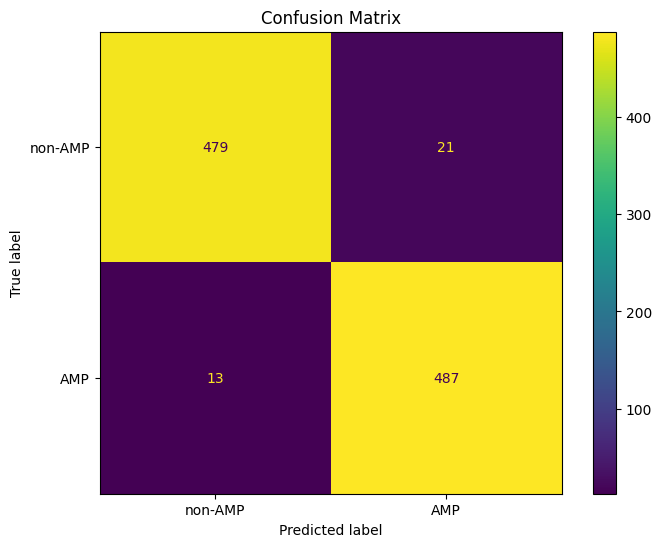

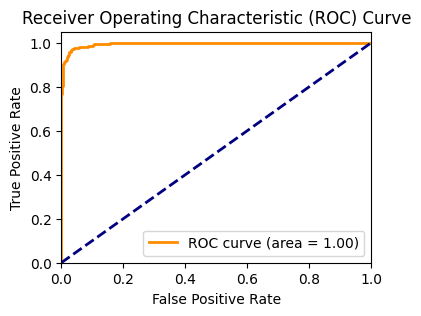

In [9]:
run_finetune_experiment(
    model_path="./models/temp_2_a_1",
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir="./amp_student_alpha_1",
    model_name="distilESM-2-AMP (a=1, temperature=2)"
)

#### facebook/esm2_t6_8M_UR50D

---- Start experimenting facebook/esm2_t6_8M_UR50D ----


Loading weights:   0%|          | 0/107 [00:00<?, ?it/s]

EsmForSequenceClassification LOAD REPORT from: facebook/esm2_t6_8M_UR50D
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
esm.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.dense.weight     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the k

Tokenizing dataset.....

facebook/esm2_t6_8M_UR50D Size Analysis
Total Parameters: 7512443 (7.51M)
Trainable Parameters: 7512443 (7.51M)
Total size in memory: 28.67MB



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.543644,0.286420,0.943562,0.944615,0.937051,0.952301
2,0.216261,0.181794,0.947533,0.948568,0.939945,0.957351
3,0.158736,0.160955,0.947249,0.947811,0.947811,0.947811
4,0.141114,0.151108,0.951787,0.952540,0.947778,0.957351
5,0.133034,0.149249,0.951787,0.952673,0.945304,0.960157


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['esm.encoder.layer.0.attention.LayerNorm.weight', 'esm.encoder.layer.0.attention.LayerNorm.bias', 'esm.encoder.layer.0.LayerNorm.weight', 'esm.encoder.layer.0.LayerNorm.bias', 'esm.encoder.layer.1.attention.LayerNorm.weight', 'esm.encoder.layer.1.attention.LayerNorm.bias', 'esm.encoder.layer.1.LayerNorm.weight', 'esm.encoder.layer.1.LayerNorm.bias', 'esm.encoder.layer.2.attention.LayerNorm.weight', 'esm.encoder.layer.2.attention.LayerNorm.bias', 'esm.encoder.layer.2.LayerNorm.weight', 'esm.encoder.layer.2.LayerNorm.bias', 'esm.encoder.layer.3.attention.LayerNorm.weight', 'esm.encoder.layer.3.attention.LayerNorm.bias', 'esm.encoder.layer.3.LayerNorm.weight', 'esm.encoder.layer.3.LayerNorm.bias', 'esm.encoder.layer.4.attention.LayerNorm.weight', 'esm.encoder.layer.4.attention.LayerNorm.bias', 'esm.encoder.layer.4.LayerNorm.weight', 'esm.encoder.layer.4.LayerNorm.bias', 'esm.encoder.layer.5.attention.LayerNorm.weight', 'esm.encoder.


Evaluating on Test Set

==============Evaluation Matrics on test set==============
Accuracy : 0.9670
Precision: 0.9569
Recall   : 0.9780
F1-score : 0.9674
MCC      : 0.9342
Latency  : 0.66 ms/sample
Speed    : 1507.66 samples/sec



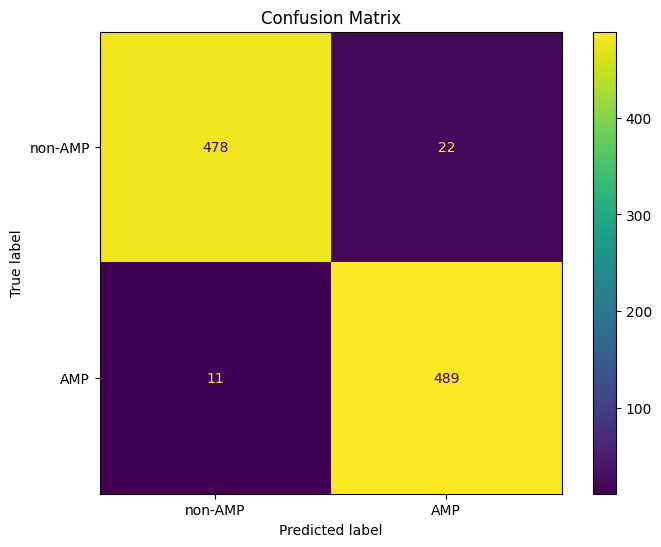

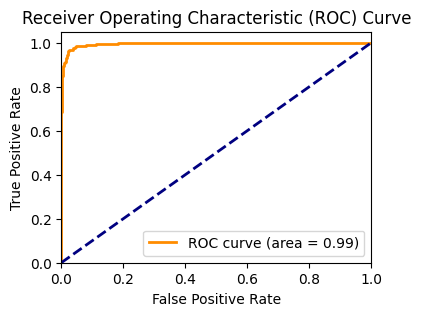

In [10]:
run_finetune_experiment(
    model_path="facebook/esm2_t6_8M_UR50D",
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir="./facebook_esm2_t6_8M_UR50D",
    model_name="facebook/esm2_t6_8M_UR50D"
)

#### yarongef/DistilProtBert

---- Start experimenting DistilProtBert ----


Loading weights:   0%|          | 0/245 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: yarongef/DistilProtBert
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expe

Tokenizing dataset.....


Map:   0%|          | 0/14102 [00:00<?, ? examples/s]

Map:   0%|          | 0/3526 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



DistilProtBert Size Analysis
Total Parameters: 230989826 (230.99M)
Trainable Parameters: 230989826 (230.99M)
Total size in memory: 881.77MB



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.178507,0.126553,0.956608,0.957700,0.943869,0.971942
2,0.105387,0.128475,0.959728,0.960090,0.961712,0.958474
3,0.062620,0.147719,0.956324,0.956669,0.959368,0.953984
4,0.035076,0.165067,0.957742,0.958530,0.950856,0.966330
5,0.018926,0.166481,0.958310,0.959064,0.951907,0.966330


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


Evaluating on Test Set

==============Evaluation Matrics on test set==============
Accuracy : 0.9750
Precision: 0.9779
Recall   : 0.9720
F1-score : 0.9749
MCC      : 0.9500
Latency  : 8.52 ms/sample
Speed    : 117.30 samples/sec



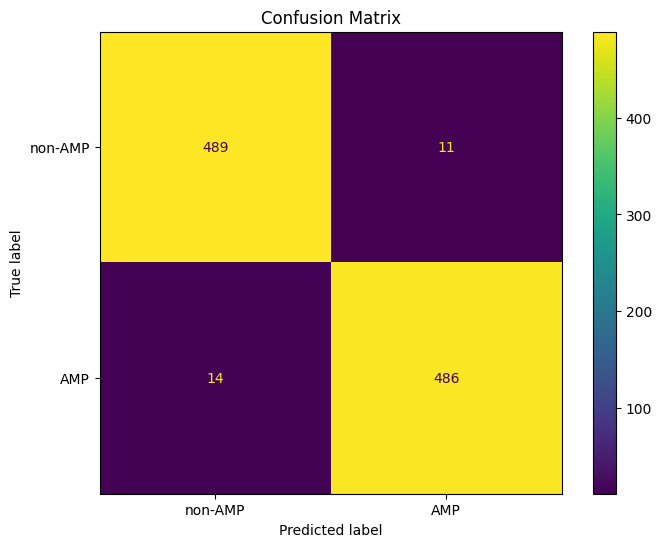

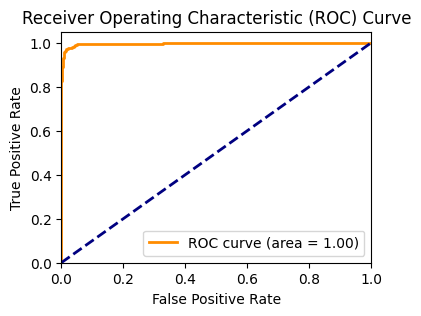

In [7]:
def process_dataset(dataset):
    dataset['seq_name'] = dataset['seq_name'].str.replace(r"[UZOB]", "X", regex=True)
    dataset["seq_name"] = dataset["seq_name"].apply(lambda x: " ".join(list(x)))
    return dataset

dataset = pd.read_csv('dataset/AMP.csv')
dataset = process_dataset(dataset)
dataset = Dataset.from_pandas(dataset).rename_column('label', 'labels')
train_dataset = dataset.train_test_split(test_size=0.2)

test_dataset = pd.read_csv('dataset/abp.indtest1.csv')
test_dataset = process_dataset(test_dataset)
test_dataset = Dataset.from_pandas(test_dataset).rename_column('label', 'labels')


run_finetune_experiment(
    model_path="yarongef/DistilProtBert",
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir=".DistilProtBert",
    model_name="DistilProtBert",
    batch_size=32
)